<a href="https://colab.research.google.com/github/NateLeMonnier/death-row-last-words-mood-assesser/blob/main/DeathRowLastWordsMoodAssesser_NathanLeMonnier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nathan LeMonnier <br>
Data Wrangling <br>
Professor Kogan <br>
Death Row Last Words Mood Assesser <br>
11-Dec-2024

# DS 2500 Exploratory Data Analysis

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

import pandas as pd
from scipy.stats import f_oneway, chi2_contingency

import statsmodels.formula.api as smf
import statsmodels.api as sm

# 1. Formulate your questions



As condemned criminals live their final moments, what do they say? Are there any patterns between statements and demographics? Do different age ranges have different things to say?

# 2. Read in your data



I was lucky (after many failed web scrapers and faulty excel files) to find a functional and complete CSV containing all Texas Death Row Inmate last statements and demographics. It made all my analysis much easier. Props to Samoora on Kaggle for the dataset!

In [ ]:
inmate_df = pd.read_csv('https://www.dropbox.com/scl/fi/hh619f6eh08pmzuk8gz8l/death_row_inmates_Texas.csv?rlkey=x1mszy8vxe4e7thg5dw37dq29&st=xcmceo3u&dl=1')
inmate_df.head()

,Execution,Last Name,First Name,TDCJNumber,Age,Date,Race,County,Last Statement
0,570,Wardlow,Billy,999137,45,7/8/2020,White,Titus,decline
1,569,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas,"Yes sir. I would like to thank God, my dad, m..."
2,568,Gardner,John,999516,64,1/15/2020,White,Collin,"Thank you thank you where's the family, ok I ..."
3,567,Runnels,Travis,999505,46,12/11/2019,Black,Potter,decline
4,566,Hall,Justen,999497,38,11/6/2019,White,El Paso,"Yeah, I want to address the Roundtree family ..."


In [ ]:
inmate_df.tail()

,Execution,Last Name,First Name,TDCJNumber,Age,Date,Race,County,Last Statement
564,5,Skillern,Doyle,518,49,1/16/1985,White,Lubbock,I pray that my family will rejoice and will fo...
565,4,Barefoot,Thomas,621,39,10/30/1984,White,Bell,"When asked if he had a last statement, he repl..."
566,3,O'Bryan,Ronald,529,39,3/31/1984,White,Harris,What is about to transpire in a few moments is...
567,2,Autry,James,670,29,3/14/1984,White,Jefferson,decline
568,1,"Brooks, Jr.",Charlie,592,40,12/7/1982,Black,Tarrant,"I, at this very moment, have absolutely no fea..."


Any inmates that refused a last statement are all represented with 'decline.'

### Last Statement Additions

To be able to tell the overall "feeling" of the Last Statements, such as forgiveness, religion, etc.., I created new columns that contain a "Rating". The "Rating" is a integer value dictating the number of times a certain subject was mentioned.

Instead of simply assigning True or False on whether a prisoner mentioned a certain subjet (like religion), this "Rating" scale will be able to sort the statements that more strongly mentioned a subject than others.

In [ ]:
inmate_df['Religion'] = 0
inmate_df['Forgiveness'] = 0
inmate_df['Criticism'] = 0
inmate_df['Innocence'] = 0
inmate_df.head()

,Execution,Last Name,First Name,TDCJNumber,Age,Date,Race,County,Last Statement,Religion,Forgiveness,Criticism,Innocence
0,570,Wardlow,Billy,999137,45,7/8/2020,White,Titus,decline,0,0,0,0
1,569,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas,"Yes sir. I would like to thank God, my dad, m...",0,0,0,0
2,568,Gardner,John,999516,64,1/15/2020,White,Collin,"Thank you thank you where's the family, ok I ...",0,0,0,0
3,567,Runnels,Travis,999505,46,12/11/2019,Black,Potter,decline,0,0,0,0
4,566,Hall,Justen,999497,38,11/6/2019,White,El Paso,"Yeah, I want to address the Roundtree family ...",0,0,0,0


Now comes the arduous task of assigning each prisoner a value.

Instead of choosing the words myself (which would have been possible but would have lacked scope), I asked ChatGPT, a popular LLM, and searched other online sources to produce a huge list of potential words for each Rating

For example, ChatGPT produced 126 words that were religiously connotated.

I thoroughly believe that I should not be docked for "plagiarism" or "cheating" under any circumstance. I am not trying to pass these words off as my own, and it is absolutely work that I could have produced myself with hours of time.

In [ ]:
religion = [
    # General
    'God', 'Lord', 'Jesus', 'Christ', 'Savior', 'Father', 'Holy', 'Heaven', 'Hell',
    'Sin', 'Sinner', 'Prayer', 'Pray', 'Praying', 'Amen', 'Faith', 'Believe', 'Belief',
    'Spirit', 'Soul', 'Redemption', 'Forgiveness', 'Repent', 'Repentance', 'Salvation',
    'Blessed', 'Bless', 'Blessing', 'Grace', 'Cross', 'Crucifix', 'Eternity', 'Eternal',
    'Divine', 'Holy Ghost', 'Holy Spirit',

    # References to God/Deities
    'Yahweh', 'Allah', 'Jehovah', 'The Almighty', 'Creator', 'Redeemer', 'Messiah',
    'The Most High', 'El Shaddai',

    # Prayer and Worship
    'Pray', 'Prayer', 'Worship', 'Praise', 'Praising', 'Hallelujah', 'Hosanna',
    'Devotion', 'Meditation', 'Thanksgiving',

    # Death and the Afterlife
    'Heaven', 'Hell', 'Eternal life', 'Afterlife', 'Resurrection', 'Paradise',
    'Judgement', 'Judgement Day', 'Rest in Peace', 'Ascend', 'Reunite', 'On the other side',

    # Religious Moral and Ethical Language
    'Good', 'Evil', 'Right', 'Wrong', 'Righteous', 'Justice', 'Mercy', 'Compassion',
    'Sin', 'Sinful', 'Guilt', 'Guilty', 'Punishment', 'Washed away', 'Cleanse', 'Pure',
    'Purity', 'Confess', 'Confession',

    # Rituals and Acts
    'Baptize', 'Baptism', 'Communion', 'Last Rites', 'Sacrament', 'Anoint',
    'Anointing', 'Confession', 'Ritual', 'Offering',

    # Religious Objects/Items
    'Cross', 'Crucifix', 'Bible', 'Scripture', 'Verse', 'Psalms', 'Hymn', 'Rosary', 'Altar',

    # Phrases with Religious Connotation
    'God bless you', 'God is good', 'May God have mercy on my soul', 'I put it in God\'s hands',
    'I have faith', 'Jesus loves you', 'I am going home', 'I will see you again',
    'I have been forgiven', 'I accept my punishment', 'Forgive them', 'I am at peace',
    'I see the light', 'My soul is ready', 'I am going to a better place',
    'Only God can judge me', 'I walk with God', 'I surrender to God',
    'The truth will set you free', 'Into your hands, I commit my spirit',
    'I have no fear'
]

forgiveness = [
    # General Words
    'Forgive', 'Forgiveness', 'Pardon', 'Mercy', 'Compassion', 'Clemency', 'Absolution',
    'Reconciliation', 'Repentance', 'Contrition', 'Redemption', 'Atonement', 'Apology',
    'Amends', 'Regret', 'Sorrow', 'Remorse', 'Penitence', 'Reparation', 'Expiation',

    # Seeking or Asking for Forgiveness
    'I ask for forgiveness', 'Please forgive me', 'Forgive my sins', 'I beg for mercy',
    'I seek redemption', 'I am sorry', 'I am deeply sorry', 'I apologize',
    'I take responsibility', 'I regret my actions', 'I hope you can find it in your heart to forgive me',
    'I repent for my wrongs', 'I accept my punishment', 'I ask for peace',
    'I atone for my sins', 'I hope for reconciliation',

    # Giving Forgiveness
    'Forgiving'
]

criticism = [
    # General Words About Criticism
    'Criticism', 'Criticize', 'Critique', 'Condemn', 'Condemnation', 'Fault', 'Flaw',
    'Injustice', 'Bias', 'Unfair', 'Unjust', 'Corruption', 'Oppression', 'Prejudice',
    'Discrimination', 'Wrong', 'Misconduct', 'Failure', 'Inequality', 'Arbitrariness',
    'Unaccountable', 'Faulty', 'Flawed', 'Ineffective', 'Inefficiency',

    # Criticism of the Legal System
    'Broken system', 'Corrupt system', 'Unjust system', 'Flawed process', 'Legal failure',
    'Systemic failure', 'Injustice', 'Unfair trial', 'Wrongfully convicted',
    'Judicial bias', 'Prosecutorial misconduct', 'Unfair sentencing', 'Inequity',
    'Miscarriage of justice', 'False accusation', 'Unreliable evidence',
    'Incompetence', 'Overreach', 'Abuse of power', 'Rigged system',
    'Unethical behavior', 'Lack of accountability', 'Lack of fairness',
    'Political influence', 'Discriminatory practices', 'Racial bias', 'Economic bias',

    # Expressions of Criticism
    'I was wrongfully convicted', 'I did not get a fair trial', 'This system is broken',
    'The justice system failed me', 'This is a miscarriage of justice',
    'The legal process is flawed', 'I am a victim of injustice',
    'The evidence was unreliable', 'I was treated unfairly', 'The system is corrupt',
    'The judge was biased', 'The prosecution was unethical', 'The jury was prejudiced',
    'I did not receive fair representation', 'The truth was ignored',
    'Justice was not served', 'I am being punished unfairly',
    'The legal system is unjust', 'This is not real justice',
    'I am a product of a failed system'
]

innocence = [
    # General Words
    'Innocent', 'Innocence', 'Wrongfully accused', 'Falsely accused',
    'Not guilty', 'Blameless', 'Exoneration', 'Framed', 'Mistake',
    'Misunderstanding', 'Error', 'Wronged', 'Truth', 'Unjustly convicted',
    'Justice denied',

    # Declaring Innocence
    'I am innocent', 'I did not do it', 'I didn’t commit the crime',
    'I was falsely accused', 'I am wrongfully convicted',
    'I have been framed', 'This is a mistake', 'I am telling the truth',
    'The truth will come out', 'I have been wronged',
    'I was in the wrong place at the wrong time', 'This is not justice',
    'I should not be here', 'I am not guilty', 'I am a victim of injustice',
    'I did not have a fair chance', 'The real culprit is still out there',
    'I was set up', 'I am being punished for something I didn’t do',

    # Phrases Declaring Unjust Judgement
    'This conviction is false', 'The evidence was fabricated',
    'I was misidentified', 'The case was mishandled',
    'The truth was ignored', 'My innocence was overlooked',
    'The system failed me', 'There is no proof I did this',
    'I was pressured into a confession', 'I was coerced',
    'I was not given a fair chance to prove my innocence',
    'The facts were twisted', 'They ignored the evidence of my innocence'
]

religion = [word.lower() for word in religion] + [org_word for org_word in religion]
forgiveness = [word.lower() for word in forgiveness] + [org_word for org_word in forgiveness]
criticism = [word.lower() for word in criticism] + [org_word for org_word in criticism]
innocence = [word.lower() for word in innocence] + [org_word for org_word in innocence]

Again, all the references for the above lists of words to ChatGPT.

Formal reference below:
“Rating Lists” Give me a list of religious connotated words. ChatGPT4o, May. version, OpenAI, 9 Dec. 2024, https://chatgpt.com
At the bottom, I convert each word to lower case to more accurately detect its use in any last statements.

**Character Statements:** Many of the last statements were strangely represented as a list of characters instead of words. I simply joined the statements together into a single sentence.

In [ ]:
for i,statement in enumerate(inmate_df['Last Statement']):
  inmate_df.iloc[i]['Last Statement'] = ''.join(str(inmate_df.iloc[i]['Last Statement']))

<ipython-input-6-2b003eed3c7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmate_df.iloc[i]['Last Statement'] = ''.join(str(inmate_df.iloc[i]['Last Statement']))


In [ ]:
import string

for i,statement in enumerate(inmate_df['Last Statement']):
  for word in str(statement).split():
    word = word.translate(str.maketrans('', '', string.punctuation)) # Method found on StackOverflow!
    if word in religion:
      inmate_df.loc[i,'Religion'] += 1
    if word in forgiveness:
      inmate_df.loc[i,'Forgiveness'] += 1
    if word in criticism:
      inmate_df.loc[i,'Criticism'] += 1
    if word in innocence:
      inmate_df.loc[i,'Innocence'] += 1
inmate_df.head()

,Execution,Last Name,First Name,TDCJNumber,Age,Date,Race,County,Last Statement,Religion,Forgiveness,Criticism,Innocence
0,570,Wardlow,Billy,999137,45,7/8/2020,White,Titus,decline,0,0,0,0
1,569,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas,"Yes sir. I would like to thank God, my dad, m...",4,1,0,0
2,568,Gardner,John,999516,64,1/15/2020,White,Collin,"Thank you thank you where's the family, ok I ...",5,3,0,0
3,567,Runnels,Travis,999505,46,12/11/2019,Black,Potter,decline,0,0,0,0
4,566,Hall,Justen,999497,38,11/6/2019,White,El Paso,"Yeah, I want to address the Roundtree family ...",0,0,0,0


In [ ]:
print(inmate_df['Religion'].value_counts())
print(inmate_df['Forgiveness'].value_counts())
print(inmate_df['Criticism'].value_counts())
print(inmate_df['Innocence'].value_counts())

Religion
0     258
1      81
2      52
3      41
4      32
6      19
7      19
5      11
8      10
9      10
10      6
11      6
12      4
15      4
18      4
16      2
13      2
23      1
27      1
24      1
20      1
50      1
28      1
30      1
14      1
Name: count, dtype: int64
Forgiveness
0    436
1     66
2     32
3     14
4     11
5      5
7      3
6      1
9      1
Name: count, dtype: int64
Criticism
0    528
1     34
2      6
3      1
Name: count, dtype: int64
Innocence
0    508
1     34
2     18
3      4
4      2
6      2
7      1
Name: count, dtype: int64


# 3. Check the packaging

In [ ]:
inmate_df.shape

(569, 13)

# 4. Look at the top and bottom of data

In [ ]:
inmate_df.head()

,Execution,Last Name,First Name,TDCJNumber,Age,Date,Race,County,Last Statement,Religion,Forgiveness,Criticism,Innocence
0,570,Wardlow,Billy,999137,45,7/8/2020,White,Titus,decline,0,0,0,0
1,569,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas,"Yes sir. I would like to thank God, my dad, m...",4,1,0,0
2,568,Gardner,John,999516,64,1/15/2020,White,Collin,"Thank you thank you where's the family, ok I ...",5,3,0,0
3,567,Runnels,Travis,999505,46,12/11/2019,Black,Potter,decline,0,0,0,0
4,566,Hall,Justen,999497,38,11/6/2019,White,El Paso,"Yeah, I want to address the Roundtree family ...",0,0,0,0


In [ ]:
inmate_df.tail()

,Execution,Last Name,First Name,TDCJNumber,Age,Date,Race,County,Last Statement,Religion,Forgiveness,Criticism,Innocence
564,5,Skillern,Doyle,518,49,1/16/1985,White,Lubbock,I pray that my family will rejoice and will fo...,1,1,0,0
565,4,Barefoot,Thomas,621,39,10/30/1984,White,Bell,"When asked if he had a last statement, he repl...",5,3,0,0
566,3,O'Bryan,Ronald,529,39,3/31/1984,White,Harris,What is about to transpire in a few moments is...,9,4,2,0
567,2,Autry,James,670,29,3/14/1984,White,Jefferson,decline,0,0,0,0
568,1,"Brooks, Jr.",Charlie,592,40,12/7/1982,Black,Tarrant,"I, at this very moment, have absolutely no fea...",12,0,0,0


# 5. Check the "n"s

To check the 'n's, I will verify that the first and last recorded execution line up with the public Texas information.

After checking, they do! The data appears to be correct.

# 6. Validate against an external knowledge or data source

To validate against an external data source, I visited a website that tackled some basic analysis of this same dataset. While I found that 54% of inmates mentioned religion, they found that 47% of inmates mentioned God. As these numbers are very close, I can safely assume that my data is validated.

# 7. Make a plot

As my question is comprised of multiple question, I will obviously have multiple plots. I also added plots that were interesting but not entirely relevant to my questions.


### Inmate Ages

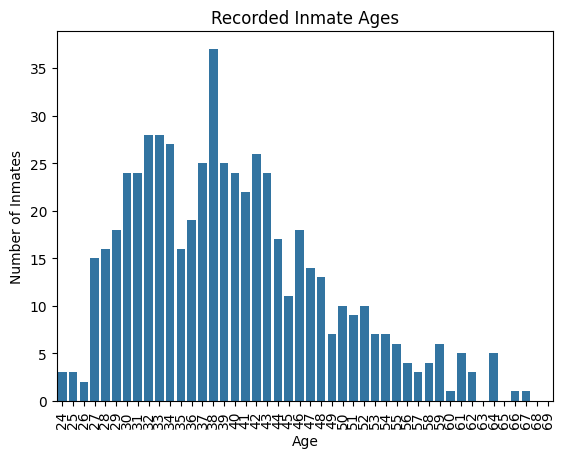

In [ ]:
age_range = []
for number in range(inmate_df['Age'].min(), inmate_df['Age'].max()):
  age_range.append(str(number))

plt.title('Recorded Inmate Ages')
sb.countplot(x='Age', data=inmate_df, order=age_range)
plt.ylabel('Number of Inmates')
plt.xticks(rotation=90)
plt.show()

The most common age (by a decent margin) is 38, and 30s are the most common age range.

### Inmate Races

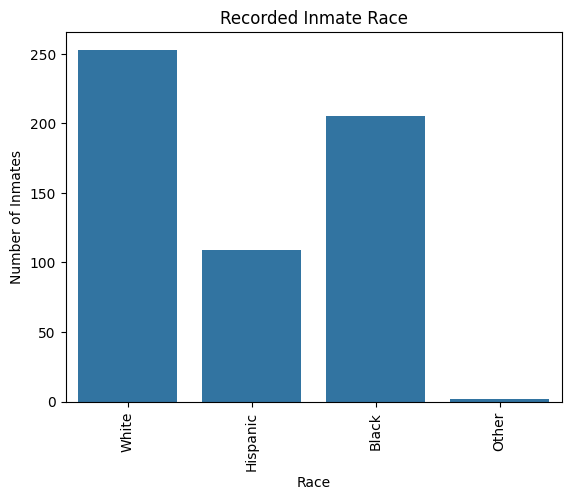

In [ ]:
plt.title('Recorded Inmate Race')
sb.countplot(x='Race', data=inmate_df)
plt.ylabel('Number of Inmates')
plt.xticks(rotation=90)
plt.show()

### Inmate Counties
For the below plot, I limited it to counties that were mentioned more than one time.

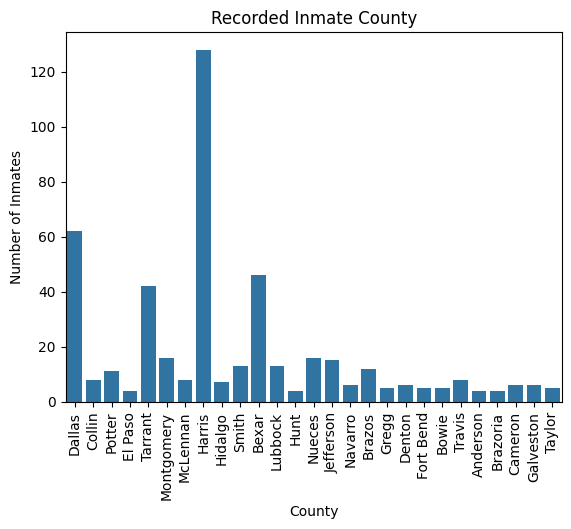

In [ ]:
county_counts = inmate_df['County'].value_counts()
counties = inmate_df.copy()
for i,county in enumerate(counties['County']):
  if (county_counts.get(county) < 4):
    counties.drop(index=i,inplace=True)

plt.title('Recorded Inmate County')
sb.countplot(x='County', data=counties)
plt.ylabel('Number of Inmates')
plt.xticks(rotation=90, size=10)
plt.show()

This one makes sense, as the most populous city in Texas is Houston, which is in Harris county.

### Race and Last Statement

In [ ]:
racetotal_counts = inmate_df.groupby('Race', as_index=False)[['Religion', 'Forgiveness', 'Innocence', 'Criticism']].sum()
racetotal_counts.head(10)

,Race,Religion,Forgiveness,Innocence,Criticism
0,Black,479,101,41,19
1,Hispanic,346,60,18,7
2,Other,15,0,0,0
3,White,648,116,50,23


Text(0.5, 1.0, 'Race and Inmate Last Statements')

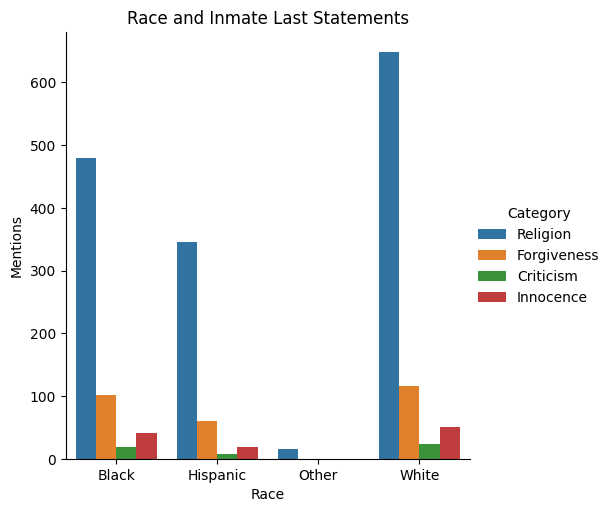

In [ ]:
melted = racetotal_counts.melt(id_vars=['Race'], value_vars=['Religion', 'Forgiveness', 'Criticism', 'Innocence'], var_name = 'Category', value_name='Mentions')

sb.catplot(data=melted, x='Race', y='Mentions', hue='Category', kind='bar')
plt.title('Race and Inmate Last Statements')

### Age and Last Statement

In [ ]:
age_range = inmate_df.copy()
for i,age in enumerate(age_range['Age']):
  if age < 30:
    age_range.loc[i,'Age'] = '20 - 30'
  if age >= 30 and age < 40:
    age_range.loc[i,'Age'] = '30 - 40'
  if age >= 40 and age < 50:
    age_range.loc[i,'Age'] = '40 - 50'
  if age >= 50 and age < 60:
    age_range.loc[i,'Age'] = '50 - 60'
  if age >= 60 and age < 70:
    age_range.loc[i,'Age'] = '60 - 70'

<ipython-input-17-504a0890cf47>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40 - 50' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  age_range.loc[i,'Age'] = '40 - 50'


In [ ]:
agetotal_counts = age_range.groupby('Age', as_index=False)[['Religion', 'Forgiveness', 'Innocence', 'Criticism']].sum()
agetotal_counts.head(10)

,Age,Religion,Forgiveness,Innocence,Criticism
0,70,0,0,0,0
1,20 - 30,99,27,12,6
2,30 - 40,811,145,43,32
3,40 - 50,401,72,38,9
4,50 - 60,128,21,14,1
5,60 - 70,49,12,2,1


Text(0.5, 1.0, 'Age and Inmate Last Statements')

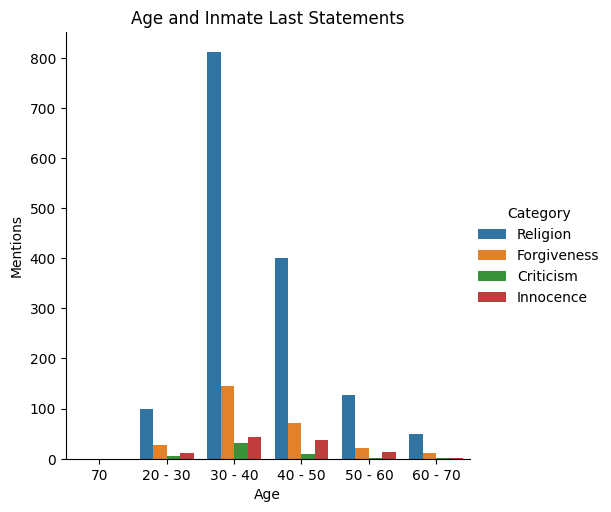

In [ ]:
melted = agetotal_counts.melt(id_vars=['Age'], value_vars=['Religion', 'Forgiveness', 'Criticism', 'Innocence'], var_name = 'Category', value_name='Mentions')

sb.catplot(data=melted, x='Age', y='Mentions', hue='Category', kind='bar')
plt.title('Age and Inmate Last Statements')

### Age and Last Statement Sentiment

Below, I used the VADER library to add new variables representing statement sentiment.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Text(0.5, 1.0, 'Age and Last Statement Sentiments')

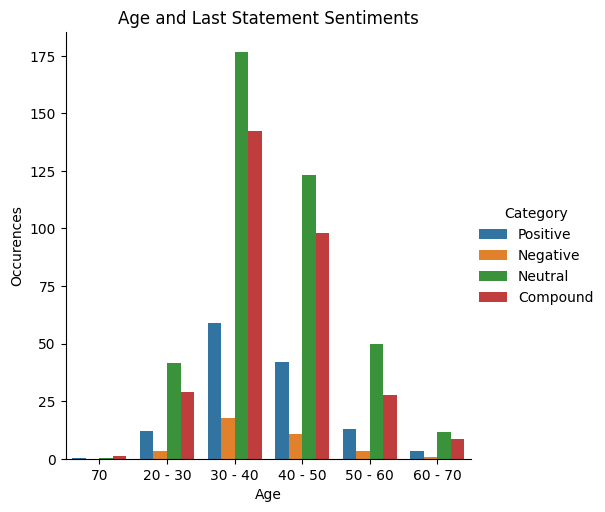

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Creating new columns containing value for the four different recognized sentiments
age_range['Statement Sentiment'] = age_range['Last Statement'].apply(lambda x: sid.polarity_scores(x))
age_range['Positive'] = age_range['Statement Sentiment'].apply(lambda score_dict: score_dict['pos'])
age_range['Negative'] = age_range['Statement Sentiment'].apply(lambda score_dict: score_dict['neg'])
age_range['Neutral'] = age_range['Statement Sentiment'].apply(lambda score_dict: score_dict['neu'])
age_range['Compound'] = age_range['Statement Sentiment'].apply(lambda score_dict: score_dict['compound'])
sentiment = age_range.copy()

agetotal_counts = sentiment.groupby('Age', as_index=False)[['Positive', 'Negative', 'Neutral', 'Compound']].sum()
agetotal_counts.head(10)

melted = agetotal_counts.melt(id_vars=['Age'], value_vars=['Positive', 'Negative', 'Neutral', 'Compound'], var_name = 'Category', value_name='Occurences')

sb.catplot(data=melted, x='Age', y='Occurences', hue='Category', kind='bar')
plt.title('Age and Last Statement Sentiments')

### Race and Last Statement Sentiments

Below, I used the VADER library to add new variables representing statement sentiment.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(0.5, 1.0, 'Race and Last Statement Sentiments')

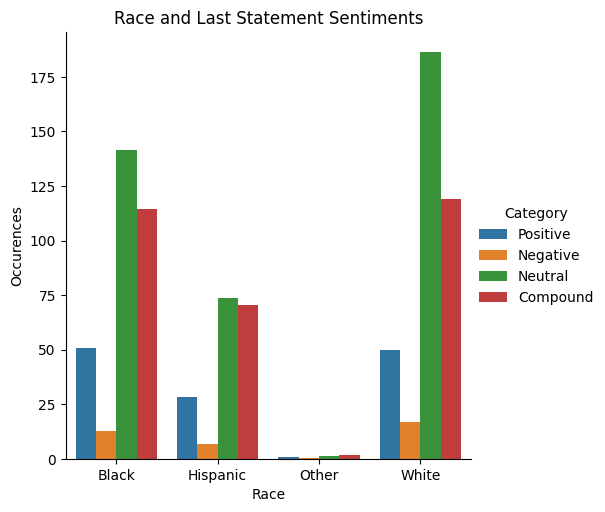

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Creating new columns containing value for the four different recognized sentiments
inmate_df['Statement Sentiment'] = inmate_df['Last Statement'].apply(lambda x: sid.polarity_scores(x))
inmate_df['Positive'] = inmate_df['Statement Sentiment'].apply(lambda score_dict: score_dict['pos'])
inmate_df['Negative'] = inmate_df['Statement Sentiment'].apply(lambda score_dict: score_dict['neg'])
inmate_df['Neutral'] = inmate_df['Statement Sentiment'].apply(lambda score_dict: score_dict['neu'])
inmate_df['Compound'] = inmate_df['Statement Sentiment'].apply(lambda score_dict: score_dict['compound'])
inmate_df.drop(columns=['Statement Sentiment'], inplace=True)
sentiment = inmate_df.copy()

agetotal_counts = sentiment.groupby('Race', as_index=False)[['Positive', 'Negative', 'Neutral', 'Compound']].sum()
agetotal_counts.head(10)

melted = agetotal_counts.melt(id_vars=['Race'], value_vars=['Positive', 'Negative', 'Neutral', 'Compound'], var_name = 'Category', value_name='Occurences')

sb.catplot(data=melted, x='Race', y='Occurences', hue='Category', kind='bar')
plt.title('Race and Last Statement Sentiments')

## Logistic Regression Model

In [ ]:
inmate_df['Happy'] = 0
for i,compound in enumerate(inmate_df['Compound']):
  if compound >= 0.05:
    inmate_df.loc[i,'Happy'] = 1
  else:
    inmate_df.loc[i,'Happy'] = 0

### Assumption One: Binary Dependent Variable

I'm using Happy as my dependent variable, so it needs to be binary.

In [ ]:
inmate_df['Happy'].value_counts()

,count
Happy,
1,390
0,179


### Assumption 2: Independent Observations

There is not a whole lot I can do with the data to verify that the observations are independent, but I will verify that there are no duplicated rows.

In [ ]:
inmate_df.duplicated().sum()

0

### Assumption 3: No Multicollinearity

To check for this, I will make a heatmap comparing the different variables

<Axes: >

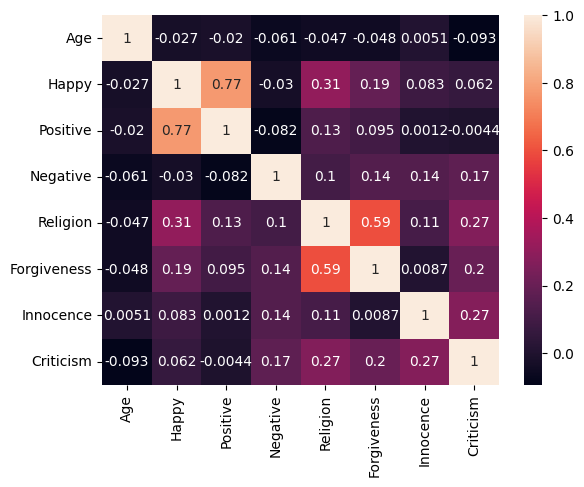

In [ ]:
inmatevalues_df = inmate_df[['Age', 'Happy', 'Positive', 'Negative', 'Religion', 'Forgiveness', 'Innocence', 'Criticism']]
inmate_corr = inmatevalues_df.corr()
sb.heatmap(inmate_corr, annot=True)

A little bit of spoilers here, but the variables that I use are all well below 0.8, which is the margin to look out for when searching for multicollinearity.

I can now begin making my logistic regression model!

In [ ]:
m1 = smf.logit(formula = 'Happy ~ Religion + Forgiveness + Innocence + Criticism', data = inmatevalues_df).fit()
m1.summary()

Optimization terminated successfully.
         Current function value: 0.514001
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Happy   No. Observations:                  569
Model:                          Logit   Df Residuals:                      564
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.1746
Time:                        18:12:37   Log-Likelihood:                -292.47
converged:                       True   LL-Null:                       -354.33
Covariance Type:            nonrobust   LLR p-value:                 8.551e-26
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0149      0.118      0.126      0.900      -0.216       0.246
Religion        0.6042      0.089      6.824      0.000       0.431       0.778
Forgiveness    -0.0223      0.191     -0.117      0.907      -0.397       0.352
Innocence       0.2646      0.213      1.241      0.215      -0.153       0.683
Criticism      -0.9218      0.409     -2.255      0.024      -1.723      -0.121
===============================================================================
"""

Both Forgiveness and Innocence have high P-Values, so I can get rid of them.

In [ ]:
m2 = smf.logit(formula = 'Happy ~ Religion + Criticism + C(Race)', data = inmate_df).fit()
m2.summary()

         Current function value: 0.510005
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Happy   No. Observations:                  569
Model:                          Logit   Df Residuals:                      563
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.1810
Time:                        18:12:37   Log-Likelihood:                -290.19
converged:                      False   LL-Null:                       -354.33
Covariance Type:            nonrobust   LLR p-value:                 5.539e-26
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2203      0.170      1.296      0.195      -0.113       0.553
C(Race)[T.Hispanic]     0.0806      0.296      0.273      0.785      -0.499       0.660
C(Race)[T.Other]       20.7676   4.89e+04      0.000      1.000   -9.59e+04    9.59e+04
C(Race)[T.White]       -0.4413      0.221     -1.996      0.046      -0.875      -0.008
Religion                0.6087      0.085      7.181      0.000       0.443       0.775
Criticism              -0.8086      0.407     -1.987      0.047      -1.606      -0.011
=======================================================================================
"""

While White inmates have a statistically significant value, it is a percentage decrease from Black inmates, which is not a logical operation to perform. Therefore, the most 'accurate' logistic model is the first one.

In [ ]:
m3 = smf.logit(formula = 'Happy ~ Religion + Criticism', data = inmatevalues_df).fit()
m3.summary()

Optimization terminated successfully.
         Current function value: 0.515578
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Happy   No. Observations:                  569
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            2
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.1721
Time:                        18:12:37   Log-Likelihood:                -293.36
converged:                       True   LL-Null:                       -354.33
Covariance Type:            nonrobust   LLR p-value:                 3.337e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0412      0.115      0.359      0.719      -0.184       0.266
Religion       0.6066      0.085      7.165      0.000       0.441       0.773
Criticism     -0.8335      0.403     -2.066      0.039      -1.624      -0.043
==============================================================================
"""

What do these values mean? Using the code given to us in class, I will convert these values into a meaningful form.

In [ ]:
odds_ratios = pd.DataFrame(
    {
        "OR": m3.params,
        "Lower CI": m3.conf_int()[0],
        "Upper CI": m3.conf_int()[1],
    })

odds_ratios = np.exp(odds_ratios)

print(odds_ratios)

                 OR  Lower CI  Upper CI
Intercept  1.042063  0.832271  1.304736
Religion   1.834276  1.553804  2.165374
Criticism  0.434518  0.197066  0.958086


As seen above, for every unit increase in religion (one additional mention), there was a 83% increase in the chance for the last statement to be ruled 'happy' by VADER. For every additional criticism, there was a 57% decrease in the chance for the last statement to be ruled 'happy' by VADER.

### Logistic Model Summary
Initially, I was disappointed with the low Pseudo R-Squared value of my logistic regression model. However, when I researched my R-Squared value, I found the article *The acceptable R-square in empirical
modelling for social science research* by Peterson Ozili, which states that in combination with parameters with low P-Squared values, a lower R-Squared value is understandable for social science research. As my research is social science, my lower R-Squared value is not a serious issue, and my third logistic regression model has meaningful results.

# 8. Try an easy solution

The most viable statistical test for each of my questions is a Chi-Squared Test of Independence. However, as the test expects two categorical variables, I will have to work around two issues.

**Issue 1: Age is not categorical**
To fix this issue, I will simply make age ranges, which will transform the countless observed ages into categories.

**Issue 2: Metions of religion are not categorical**
To fix this issue, I will simply make 'mention' ranges, which will create ranges for the number of times religion was mentioned.

In [ ]:
# problem setup

# First, I will put each range of religion mention into ranges
religion_range = inmate_df.copy()
for i,religion in enumerate(religion_range['Religion']):
  if religion == 0:
    religion_range.loc[i,'Religion'] = '0'
  if religion > 0 and religion <= 2:
    religion_range.loc[i,'Religion'] = '2 - 4'
  if religion >= 3 and religion <= 7:
    religion_range.loc[i,'Religion'] = '3 - 7'
  if religion >= 8 and religion <= 15:
    religion_range.loc[i,'Religion'] = '8 - 15'
  if religion >= 16 and religion <= 50:
    religion_range.loc[i,'Religion'] = '16 - 50'

# The idea to use pandas 'crosstab' to create a contingency table found on Stack overflow! I did not copy any code, just utilized the concept.
poptable = pd.crosstab(inmate_df['Happy'], religion_range['Religion'])
popstyled_table = poptable.style.set_caption('Religion and Happiness')
display(popstyled_table)

# results
stat, p, dof, expected = chi2_contingency(poptable)
print('Statistic: {}'.format(stat))
print('P Value: {}'.format(p))
print('Expected Frequencies')
print(expected)

<ipython-input-30-4d538180a437>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  religion_range.loc[i,'Religion'] = '0'


Religion,0,16 - 50,2 - 4,3 - 7,8 - 15
Happy,,,,,
0,149,0,16,12,2
1,109,13,117,110,41


Statistic: 152.7556372998422
P Value: 5.22578217212479e-32
Expected Frequencies
[[ 81.16344464   4.08963093  41.8400703   38.37961336  13.52724077]
 [176.83655536   8.91036907  91.1599297   83.62038664  29.47275923]]


Seen above (with a statistically significant P-Value), inmates that did not mention religion a single time were observed happy (by VADER) almost half the number of times there would have been with no correlation.

There are other significant pattern, but each contributes to a trend of inmates that mentioned religion being observed as 'unhappy' many times less than what would have been observed without correlation. In other words, inmates were 'less unhappy' if they mentioned religion. Interesting!

In [ ]:
age_range['Happy'] = 0
for i,compound in enumerate(age_range['Compound']):
  if compound >= 0.05:
    age_range.loc[i,'Happy'] = 1
  else:
    age_range.loc[i,'Happy'] = 0

In [ ]:
# problem setup

# The idea to use pandas 'crosstab' to create a contingency table found on Stack overflow! I did not copy any code, just utilized the concept.
poptable = pd.crosstab(age_range['Happy'], age_range['Age'])
popstyled_table = poptable.style.set_caption('Age and Happiness')
display(popstyled_table)

# results
stat, p, dof, expected = chi2_contingency(poptable)
print('Statistic: {}'.format(stat))
print('P Value: {}'.format(p))
print('Expected Frequencies')
print(expected)

Age,70,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70
Happy,,,,,,
0,0,21,74,53,26,5
1,1,36,179,123,40,11


Statistic: 3.8734000760044895
P Value: 0.567783585543552
Expected Frequencies
[[  0.31458699  17.9314587   79.59050967  55.36731107  20.76274165
    5.03339192]
 [  0.68541301  39.0685413  173.40949033 120.63268893  45.23725835
   10.96660808]]


Possibly interesting findings, but they are thwarted by a high P-Value, meaning they are not statistically significant.

In [ ]:
# problem setup

# The idea to use pandas 'crosstab' to create a contingency table found on Stack overflow! I did not copy any code, just utilized the concept.
poptable = pd.crosstab(inmate_df['Happy'], inmate_df['Race'])
popstyled_table = poptable.style.set_caption('Race and Happiness')
display(popstyled_table)

# results
stat, p, dof, expected = chi2_contingency(poptable)
print('Statistic: {}'.format(stat))
print('P Value: {}'.format(p))
print('Expected Frequencies')
print(expected)

Race,Black,Hispanic,Other,White
Happy,,,,
0,62,26,0,91
1,143,83,2,162


Statistic: 6.36858717332932
P Value: 0.09499169284435298
Expected Frequencies
[[ 64.49033392  34.28998243   0.62917399  79.59050967]
 [140.50966608  74.71001757   1.37082601 173.40949033]]


Again, while the P-Value was closer, it was not low enough for the results to be statistically significant.

In [ ]:
# problem setup

# The idea to use pandas 'crosstab' to create a contingency table found on Stack overflow! I did not copy any code, just utilized the concept.
poptable = pd.crosstab(inmate_df['Happy'], inmate_df['Criticism'])
popstyled_table = poptable.style.set_caption('Criticism and Happiness')
display(popstyled_table)

# results
stat, p, dof, expected = chi2_contingency(poptable)
print('Statistic: {}'.format(stat))
print('P Value: {}'.format(p))
print('Expected Frequencies')
print(expected)

Criticism,0,1,2,3
Happy,,,,
0,170,8,1,0
1,358,26,5,1


Statistic: 2.192707600027679
P Value: 0.5333861745906969
Expected Frequencies
[[1.66101933e+02 1.06959578e+01 1.88752197e+00 3.14586995e-01]
 [3.61898067e+02 2.33040422e+01 4.11247803e+00 6.85413005e-01]]


Another high P-Value—the results are not statistically significant.

In [ ]:
# problem setup

# First, I will put each range of religion mention into ranges
religion_range = inmate_df.copy()
for i,religion in enumerate(religion_range['Religion']):
  if religion == 0:
    religion_range.loc[i,'Religion'] = '0'
  if religion > 0 and religion <= 2:
    religion_range.loc[i,'Religion'] = '2 - 4'
  if religion >= 3 and religion <= 7:
    religion_range.loc[i,'Religion'] = '3 - 7'
  if religion >= 8 and religion <= 15:
    religion_range.loc[i,'Religion'] = '8 - 15'
  if religion >= 16 and religion <= 50:
    religion_range.loc[i,'Religion'] = '16 - 50'

# The idea to use pandas 'crosstab' to create a contingency table found on Stack overflow! I did not copy any code, just utilized the concept.
poptable = pd.crosstab(inmate_df['Race'], religion_range['Religion'])
popstyled_table = poptable.style.set_caption('Race and its Affect on Age')
display(popstyled_table)

# results
stat, p, dof, expected = chi2_contingency(poptable)
print('Statistic: {}'.format(stat))
print('P Value: {}'.format(p))
print('Expected Frequencies')
print(expected)

<ipython-input-35-e7413b14999a>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  religion_range.loc[i,'Religion'] = '0'


Religion,0,16 - 50,2 - 4,3 - 7,8 - 15
Race,,,,,
Black,103,4,51,32,15
Hispanic,41,4,25,31,8
Other,0,0,1,0,1
White,114,5,56,59,19


Statistic: 16.957112157021268
P Value: 0.15121774262799986
Expected Frequencies
[[9.29525483e+01 4.68365554e+00 4.79173989e+01 4.39543058e+01
  1.54920914e+01]
 [4.94235501e+01 2.49033392e+00 2.54780316e+01 2.33708260e+01
  8.23725835e+00]
 [9.06854130e-01 4.56942004e-02 4.67486819e-01 4.28822496e-01
  1.51142355e-01]
 [1.14717047e+02 5.78031634e+00 5.91370826e+01 5.42460457e+01
  1.91195079e+01]]


After all that work, more dissapointing *not* statistically significant results.

# Write Up

### I. EDA Summary

---
Before conducting the main write-up/exploration of my final project, I will summarize my Exploratory Data Analysis done above. My central question(s) focused solely on Texas Death Row Inmate’s last statements and looked for any patterns, trends, or correlations in the last statements and inmate demographics. <br>
The data set that I used varied wildly throughout my work. Originally, I built a web-scraper to scrape the public Texas .gov website, but was quickly met with many issues. The website had a type of block against any scrapers, and each attempt was met with immediate removal from the website. While the web-scraper did not work, it led me to discover the data set on Kaggle in a simplified version. While it would have been ideal to find the data set originally, the web scraper only lost me a couple of hours and was excusable.<br>
While I did not have any data to clean, I did have data to add. By searching for words with certain connotations (religion, forgiveness, etc..), I assigned each statement a "Rating" indicating the strength with which they mentioned each respective connotation. I also added data from the VADER library which identified different sentiments in the statements, from which I created a generalized "Happy" value.<br>
The main method I used worked around those two additions. First, I created multiple somewhat unrelated graphs that addressed important data about the inmates, such as age, race, and county or origin. Second, I created Seaborn cat plots to measure multiple variables, such as VADER sentiments and mentioned topics. I separated each cat plot into the respective groupings, such as age and race. Both of these plots identified patterns in the data, such as White prisoners being slightly more negative than what was expected. By using a Chi-Squared Test of Independence, I was able to identify that inmates who mentioned religion were "less unhappy" than they would have been without a correlation between the two. Any other findings are discussed below, in my core write-up. Again, my results including my well-designed data visualization and statistical test (as seen in the rubric), are all discussed below in my core write-up.<br>
The limitations of my data and analysis approach are discussed below, but I will summarize. The data inherently lacked scope to understand patterns either on a country or global scale, as it was only for Texas. Also, my analysis relied heavily on self-constructed variables to identify different variables. However, when comparing to a blog page that simply found the percentage that inmates would mention religion, my results were very close, indicating that my way of measuring was accurate.
My core write-up is below.


### II. Core Write-Up

---
Summarize the central argument/question of your final project
Describe the data sets you used to answer this question and why it matches your question
Explain how you retrieved (if it's new) and cleaned the data
Summarize main method you used and outputs they produced (visualizations, tables, test, etc.). This should be much more detailed and extensive than EDA you've done for module assignments.
Include your results, including well-designed data visualization and at least one statistical test.
Describe the limitations of your data and analysis approach.

In their final moments on earth, what do death row inmates say? While it is hard to know in other countries, many US states have kept track in public databases. Being the state with the highest total executions and second highest execution rate, Texas's death row inmate’s last statements highlight trends seen across the entire country. Countless inmates seek forgiveness, while a majority mention their God in their final moments. In modern times, up to a third of Americans feel lonely every week, as shown in a poll by Pschology.org. It is undeniable that while lying tied down on the execution table, Texas death row inmates are lonely. By analyzing each Texas Death Row Inmate’s last statement, patterns can be found that highlight sentiments all Americans feel—such as spirituality and forgiveness—and sentiments that many prisoners share–such as a sense of innocence and criticism of the US legal system. <br>
Before any statement analysis, it is important to understand the demographics of the inmates. The most common executed age is thirty-eight, just under half of the expected US lifespan. Furthermore, the most executed age range is inmates in their thirties, a depressingly low age to die. When combined with the fact that most death row inmates spend up to a decade in prison before their execution date arrives, their thirties become twenties. Many inmates live under a fourth of the expected US lifespan before they commit an awful crime and are sentenced to life in prison until execution. The most common home county seen in death row inmates is Harris, which is the county that Houston lies in. This is unsurprising, as cities normally hold higher crime rates than suburban or rural areas. From the demographics, the most executed Texan is a twenty-year-old from Houston.<br>
In over 7% of the last statements, death row inmates criticize the US legal system. For example, when executed in 1984, Ronald O’Bryan exclaimed “What is about to transpire in a few moments is wrong!” He goes on to explain that humans can make mistakes and that his execution is not a guaranteed fault in the US legal system. In a moment of compassion, O’Bryan forgives all who partook in his execution, excusing them for their human error. However, not all inmates are so forgiving. In his last statement, Gary Graham criticizes the Texas state government’s racial discrimination. He states “That [he is] an innocent black man that is being murdered”, and that his execution is an outrage. Without full knowledge of his case, it is hard to make a conclusion about Graham’s fate. However, as Texas is the third most racist state in the US, it is possible that he was wrongfully executed. In comparison to other last statements, most inmates avoid criticism and instead turn towards forgiveness or religion.<br>
In over 10% of the last statements, death row inmates plea for their innocence. As seen in the case of Gary Grahams, they hold that they did not commit the crime and that their execution is wrong. In a 1999 case, James Beathard stated that his entire prosecution was based on a lie. He claimed that “[he was] dying tonight based on testimony”, a testimony that was entirely false. He calls out to his family, speaking of them one last time in his final moments while claiming how lucky he is to be a father. Without knowing the details of his case, we cannot know if he was truthful. However, it is undeniable that he sought family in his final moments. In a saddening twist, a prisoner executed in 1993 speaks of Gary Graham, the man who criticized the US legal system for its racial discrimination. The prisoner, Leonel Herrera, stated that “[he was] innocent, innocent, innocent.” He claims that something terrible is happening in the US and bids God to bless anyone who hears his final words. In his case file, it is found that Herrera was sentenced by a dying police officer’s final moments, in which he recognized Herrera’s mugshot. While it is impossible to know the truth, an execution based on one man’s words is saddening.
The most common pattern in the death row inmate’s last statements is religion, as nearly 57% of inmates call out to God in their final moments. In a 2000 execution, James Richardson called out to God fifty times throughout his last statement. While he does not claim innocence, Richardson seeks forgiveness from God, the only action left for a man in his situation. While it cannot be known what causes humans to commit awful crimes, it is undeniable that many inmates treat their crimes as the single worst moment of their lives. In his dying moments, Richardson prays with his visiting family after asking the warden if they can hear him. Instead of spite, Richardson turns to forgiveness and spirituality. To combat his heinous past, he turns to his family. In a pattern seen in countless other last statements, Richardson finishes his life on a positive note, the most positive note that a man tied to an execution table can achieve. While his crimes will never disappear, his humanity can be seen in his final moments.<br>
While many global patterns can be seen in the data, my chosen dataset only covers a single US state. Many countries execute at a much, much higher rate than the US. Chinese execution information is not released to the public, but it has been estimated that over a thousand Chinese citizens are executed yearly, an entirely different scope than what is seen in the US, which averages around 24. Furthermore, my statistical analysis lacks certain variables that would improve their effectiveness while relying on sub-optimal measurements, such as the VADER value representing happiness. I also cannot obtain the entire scope of US executions, as my datasets only cover one state. However, with the limited dataset available to the public, I hold that any analysis is going to run into issues. By utilizing multiple techniques, such as my logistic regression model and seaborn plots, I was able to detect patterns accurately.
In hindsight, death row inmate’s last statements very often reflect certain ideals. Forgiveness from the victim’s families—many inmates attempt to find forgiveness in the surviving family of their victims to uncertain success. Forgiveness from God—countless inmates seek divine forgiveness for the choices that they have made. Pleas of innocence—many inmates attempt one final plea for innocence, all answered with the same electrical response. Identifying these patterns does not make the executions less saddening. With or without the world noticing, these inmates are put to death. It is difficult to make conclusions about the morality of the death sentence, but it is undeniable that any human is resonant in their final moments. Forgiveness, sadness, and please for innocence—any human would be able to understand.

